# Common import

In [28]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.tools.visualization import circuit_drawer
from qiskit import Aer
from qiskit import execute
from qiskit import transpile
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error
from qiskit.providers.models.backendconfiguration import QasmBackendConfiguration


import numpy as np
import scipy.sparse.linalg as sla
import copy
import networkx as nx
import matplotlib.pyplot as plt
import random
from itertools import combinations, groupby




In [29]:
#filter dictionary

In [30]:
def filterTheDict(dictObj, callback):
    newDict = dict()
    # Iterate over all the items in dictionary
    for (key, value) in dictObj.items():
        # Check if item satisfies the given condition then add to new dict
        if callback((key, value)):
            newDict[key] = value
    return newDict

# Print gates of the QuantumCircuit

In [79]:


def print_gates(qc):
    print(len(qc.data))
        #for gate in qc.data:
    #   print('\ngate name:', gate[0].name) 



# Description of gates

In [32]:
#Description Gates
class Gates:
    #dictionary {name gate: number qubit}
    gates = {'cx': 2}
    #get number qubits for gate
    @staticmethod    
    def get_number_qubits(gate_name):
        if gate_name not in Gates.gates:
            return 1
        return Gates.gates.get(gate_name)

# Class of the Platform

In [33]:
class QPlatform:
    #nqubit - max number of qubits on platform
    #basis_gates_price - is dictionary of price gates accessed on the platform
    def __init__(self, nqubit, basis_gates_price, stuffs_price):
        self.nqubit = nqubit
        self.basis_gates_price = basis_gates_price
        self.stuffs_price = stuffs_price
        noise_model = NoiseModel()
        noise_model.add_basis_gates(self.get_basis_gates())
        self.simulator = AerSimulator(noise_model=noise_model)

    #return array of basis_gates       
    def get_basis_gates(self):
        return list(self.basis_gates_price.keys())
    #get price of stuff
    def get_stuff_price(self, stuff_name):
        if stuff_name not in self.stuffs_price:
            return 0.0
        return self.stuffs_price.get(stuff_name)
    #get price of basis gate
    def get_gate_price(self, gate_name):
        if gate_name not in self.basis_gates_price:
            return 0.0
        return self.basis_gates_price.get(gate_name)
    #get cost of circuit item
    def get_cost_circuit_item(self, item_name):
        return self.get_gate_price(item_name)* Gates.get_number_qubits(item_name) + self.get_stuff_price(item_name)

    #set and convert the circuit to basis gates circuit
    def set_basis_circuit(self, circuit):
        self.qc_basis = transpile(circuit, self.simulator)
        return self.qc_basis
    #get basis circuit
    def get_basis_circuit(self):
        return self.qc_basis
    #cost of circuit
    def cost_circuit(self):
        cost = 0.0
        for gate in self.qc_basis.data:
            cost += self.get_cost_circuit_item(gate[0].name)
        return cost
    #cost of access to platphorm
    def cost_access(self):
        return self.get_stuff_price('access')
    #cost of running circuit
    def cost_running(self, shots):
        return shots*self.cost_circuit() + self.cost_access()
    #cost of multi running circuit
    def cost_multi_running(self, count, shots):
        return count * self.cost_running(shots)
    #cost task
    def cost(self, circuit, count, shots):
        self.set_basis_circuit(circuit)
        return self.cost_multi_running(count, shots)
    
    

# Platform factory

IbmQ platform factory

In [34]:
def get_ibmq_basis_gates():
    return ['id', 'rz', 'sx', 'x', 'cx'];

In [35]:
def get_common_price(gates, price):
    return  { i : price for i in gates }

In [36]:
def get_price_gates_ibmq_127():
    return {
        'id': 0.0,
        'rz': 0.00003,
        'sx': 0.00008,
        'x':0.00008,
        'cx': 0.0001
    }

In [37]:
def ibmq_7_factory():
    return QPlatform(7, get_common_price(get_ibmq_basis_gates(), 0.0), {'access':0.0, 'measure':0.0})
def ibmq_27_factory():
    return QPlatform(27, get_common_price(get_ibmq_basis_gates(), 0.00001), {'access':0.1, 'measure':0.00001})
def ibmq_127_factory():
    return QPlatform(127, get_price_gates_ibmq_127(), {'access':0.25, 'measure':0.00001})



Ionq platform factory

In [38]:
#from qiskit_ionq import IonQProvider

#def get_ionq_gates():
#    provider = IonQProvider()
#    simulator_backend = provider.get_backend("ionq_simulator")
#    return simulator_backend.configuration().basis_gates
#def ionq_factory():
#    return QPlatform(20, get_common_price(get_ionq_gates(), 0.00001), {'access':0.25, 'measure':0.0001})



# Available Platforms for circuit

In [39]:
# Available Platforms for circuit
class AvailablePlatforms:
    #constructor 
    def __init__(self, circuit):
        self.platforms = {
             'IbmQ_7qubits': ibmq_7_factory(),
             'IbmQ_27qubits': ibmq_27_factory(),
             'IbmQ_127qubits': ibmq_127_factory(),
#             'IonQ': ionq_factory()
        }
        for key in self.platforms:
            self.platforms[key].set_basis_circuit(circuit)
           
        self.circuit = circuit

    #get suite platforms for circuit
    def get_suite_platforms(self):
        num_qubits = self.circuit.num_qubits
        return filterTheDict(self.platforms, lambda elem: elem[1].nqubit >= num_qubits)
    #get keys of all platforms
    def get_name_platforms(self):
        return list(self.platforms.keys())
    #get keys of suite platforms
    def get_name_suite_platforms(self):
        return list(self.get_suite_platforms().keys())
    #get cost of platform
    def get_cost_platform(self, platform_name, count, shots):
        if platform_name not in self.platforms:
            return 0.0
        return self.platforms.get(platform_name).cost(self.circuit, count, shots)
    #get basis gate circuit     
    def get_basis_circuit(self,platform_name):
        if platform_name not in self.platforms:
            return self.circuit
        return self.platforms.get(platform_name).get_basis_circuit()
        #get basis gate circuit     
    def get_basis_gates(self,platform_name):
        if platform_name not in self.platforms:
            return []
        return self.platforms.get(platform_name).get_basis_gates()

    #is platform suite for circuit
    def is_suite(self, platform_name):
        return platform_name in self.get_suite_platforms()
    #get max qubits
    def get_number_qubits(self, platform_name):
        if platform_name not in self.platforms:
            return 0
        return self.platforms.get(platform_name).nqubit
    #cost of circuit
    def cost_circuit(self, platform_name):
        if platform_name not in self.platforms:
            return 0.0
        return self.platforms.get(platform_name).cost_circuit()
    #cost of access to platphorm
    def cost_access(self, platform_name):
        if platform_name not in self.platforms:
            return 0.0
        return self.platforms.get(platform_name).cost_access()
    #cost of running circuit
    def cost_running(self, platform_name, shots):
        if platform_name not in self.platforms:
            return 0.0
        return self.platforms.get(platform_name).cost_running(shots)
    #cost of multi running circuit
    def cost_multi_running(self, platform_name, count, shots):
        if platform_name not in self.platforms:
            return 0.0
        return self.platforms.get(platform_name).cost_multi_running(count, shots)
   
        
                 

# PlatformsViewController

In [98]:
class PlatformsViewController:
    #constructor 
    def __init__(self, circuit):
        self.platforms = AvailablePlatforms(circuit)
    #get available platforms
    def platforms():
        return self.platforms
    #print list platform
    def print_platforms(self, list_name_platforms):
        for platform_name in list_name_platforms:
            print(platform_name) 
    def print_all_platforms(self):
        self.print_platforms(self.platforms.get_name_platforms())
    def print_suite_platforms(self):
        self.print_platforms(self.platforms.get_name_suite_platforms())
    def print_list_cost_platforms(self, count, shots):
        cost = []
        for platform_name in self.platforms.get_name_platforms():
            if  self.platforms.is_suite(platform_name):
                print('name: ' + platform_name + ' cost: ' + f'{self.platforms.get_cost_platform(platform_name, count, shots):.5f}')
            else:
                print('name: ' + platform_name + ' is not available for this circuit')
                
    def get_cost_7(self, count, shots):
        return self.platforms.get_cost_platform('IbmQ_7qubits', count, shots)
    
    def get_cost_27(self, count, shots):
        return self.platforms.get_cost_platform('IbmQ_27qubits', count, shots)
    
    def get_cost_127(self, count, shots):
        return self.platforms.get_cost_platform('IbmQ_127qubits', count, shots)    
    
    def print_card_of_platform(self, platform_name):
        print('__________________________________________________________')
        print('platform: ' + platform_name + ' max number qubits:' + str(self.platforms.get_number_qubits(platform_name)))
        print('basis gates is ')
        print(self.platforms.get_basis_gates(platform_name))
        print('Circuit')
        cir = self.platforms.get_basis_circuit(platform_name)
        #print(cir)
        #cir.draw(output='mpl')
        
        
    def print_card_of_suite_platfotm(self, platform_name, count, shots):
        self.print_card_of_platform(platform_name)
        print('cost: ' + f'{self.platforms.get_cost_platform(platform_name, count, shots):.5f}')
        print('cost per circuit: ' + f'{self.platforms.cost_circuit(platform_name):.5f}')
        print('cost per access to platform: ' + f'{self.platforms.cost_access(platform_name):.5f}')
        print('cost per running ' + str(shots) + ' shots: ' + f'{self.platforms.cost_running(platform_name, shots):.5f}')
        print('Cost per task launch (' + str(count) + ' times for ' + str(shots) + ' shots) : ' + f'{self.platforms.cost_multi_running(platform_name, count, shots):.5f}')
        
        


        
    def print_card_of_not_suite_platfotm(self, platform_name):
        self.print_card_of_platform(platform_name)
        print('Platform is not available for this circuit')
        
        
    def print_list_card_of_platfotm(self, count, shots):
        for platform_name in self.platforms.get_name_platforms():
            if  self.platforms.is_suite(platform_name):
                self.print_card_of_suite_platfotm(platform_name, count, shots)
            else:
                self.print_card_of_not_suite_platfotm(platform_name)
    

# Creating circuit QAOA

In [99]:
# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for nod in list(G.nodes()):
            qc.rz(2 * gamma[irep]*G.nodes[nod]["weight"], nod)
            
            
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep]*G.edges[pair]["weight"], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc


# Creating a graph

In [100]:
def get_graph():
    nodes = 4

    # Energy cost for having node occupied. It is negative so it is favourable for having this occupied.
    weights_nodes = [-2,-2,-2,-2,-2,-2]

    # Cost for having two connected nodes occupied. This may counteract the positive benefit (weights_nodes)
    # for having the nodes occupied, and leads to the complexity for the problem.
    weights_edges = [1,2,2,1]

    random.seed(1)

    G = nx.Graph()
    for nn in range(0,nodes):
        G.add_nodes_from([(nn,{'weight': weights_nodes[nn]})])
    

    edges = combinations(range(nodes), 2)
    iter=0
    for _, node_edges in groupby(edges, key=lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edges_from([(random_edge[0], random_edge[1],{'weight': weights_edges[iter]})])
        iter += 1

        for e in node_edges:
            if random.random() < 0.4:
                G.add_edges_from([(e[0], e[1],{'weight': weights_edges[iter]})])
                iter += 1
    return G

#plt.figure(figsize=(8,5))
#nx.draw(G, node_color='lightblue', 
#        with_labels=True, 
#        node_size=500)

    

# Building qaoa for graph

In [101]:
def build_qaoa_circuit(p):
    #p = 2
    theta0 = [1.0]*2*p
    # Number of quantum measurements each time the quantum circuit is called
    shotsin = 200

    # We have random outcomes for the measurements.
    # So for the simulation it is good practice to seed the random number generator
    seed = 2
    G = get_graph()
    qc = create_qaoa_circ(G, theta0)
    return qc



# Build and draw qaoa

In [102]:
import numpy
qc= []
for p in range(2,11):
    qc.append(build_qaoa_circuit(p))
    #qc[p-2].draw("mpl")

# Convert circuit to basis gates of IBMQ

In [103]:
def get_IBMQ_noise(qc):
    noise_model = NoiseModel()
    noise_model.add_basis_gates(['id', 'rz', 'sx', 'x', 'cx'])
    sim_noise = AerSimulator(noise_model=noise_model)

    qc_noise = transpile(qc, sim_noise)
    return qc_noise
    

# Convert qc to IBMQ qc

In [104]:
qc_ibmq =[]

for p in range(2,11):
    qc_ibmq.append( get_IBMQ_noise(qc[p-2]))
    circuit = qc_ibmq[p-2]
    #circuit.draw(output='mpl')


# Print gates of the qoao circuit

In [105]:
for p in range(2,11):
    print( 'p= %i'%p)
    print_gates(qc[p-2])

p= 2
33
p= 3
45
p= 4
57
p= 5
69
p= 6
81
p= 7
93
p= 8
105
p= 9
117
p= 10
129


# Print gates of the qoao circuit in ibmq

In [106]:
for p in range(2,11):
    print('p= %i'%p)
    print_gates(qc_ibmq[p-2])

p= 2
81
p= 3
113
p= 4
145
p= 5
177
p= 6
209
p= 7
241
p= 8
273
p= 9
305
p= 10
337


# Calculation cost of task

In [110]:
# 7 qubit systems is free, we calculate for 27 and 127 qubits system
costs27 = []
costs127 = []
costs7 = []
for p in range(2,11):
    print('p=%i'%p)
    view = PlatformsViewController(qc[p-2])
    cost7 = view.get_cost_7(2, 1000)
    costs7.append(cost7)
    cost27 = view.get_cost_27(2, 1000)
    costs27.append(cost27)
    cost127 = view.get_cost_127(2, 1000)
    costs127.append(cost127)
    print('cost with 7 qubits %.2f $, with 27 qubits %.2f $ and with 127 qubits %.2f $ '%(cost7, cost27, cost127) )
    #view.print_list_cost_platforms(2, 1000)
    #view.print_list_card_of_platfotm(2, 1000)
    #cost.append(view.total_costs)

p=2
cost with 7 qubits 0.00 $, with 27 qubits 2.12 $ and with 127 qubits 12.58 $ 
p=3
cost with 7 qubits 0.00 $, with 27 qubits 2.92 $ and with 127 qubits 18.02 $ 
p=4
cost with 7 qubits 0.00 $, with 27 qubits 3.72 $ and with 127 qubits 23.46 $ 
p=5
cost with 7 qubits 0.00 $, with 27 qubits 4.52 $ and with 127 qubits 28.90 $ 
p=6
cost with 7 qubits 0.00 $, with 27 qubits 5.32 $ and with 127 qubits 34.34 $ 
p=7
cost with 7 qubits 0.00 $, with 27 qubits 6.12 $ and with 127 qubits 39.78 $ 
p=8
cost with 7 qubits 0.00 $, with 27 qubits 6.92 $ and with 127 qubits 45.22 $ 
p=9
cost with 7 qubits 0.00 $, with 27 qubits 7.72 $ and with 127 qubits 50.66 $ 
p=10
cost with 7 qubits 0.00 $, with 27 qubits 8.52 $ and with 127 qubits 56.10 $ 


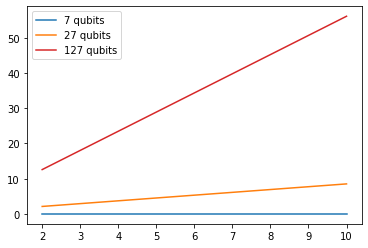

In [112]:
import matplotlib.pyplot as plt

p = range(2,11)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(p, costs7, color='tab:blue', label = '7 qubits')
ax.plot(p, costs27, color='tab:orange', label = '27 qubits')
ax.plot(p, costs127, color= 'tab:red', label = '127 qubits')
ax
plt.legend()